# Importing The Main Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Activation, Add, ZeroPadding2D,AveragePooling2D

2024-10-06 00:46:23.457123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 00:46:23.530449: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 00:46:23.552570: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 00:46:23.704761: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-06 00:46:25.084399: W tensorflow/compiler/tf2

# Creating VGG-16 Backbone

In [3]:
"""
    VGG 16 Model with No Fully Connected Layers present. Used primarily as the backbone for the Mask RCNN  
"""
class VGG_16_NFCL(tf.keras.Model):
    def __init__(self):
        super(VGG_16_NFCL, self).__init__()

        # Layer 1
        self.conv_1a = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name="conv_1A")
        self.conv_1b = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name="conv_1B")
        self.max_pool_1a = MaxPool2D(pool_size=2, strides=2, padding='same', name="max_pool1A")

        # Layer 2
        self.conv_2a = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name="conv_2A")
        self.conv_2b = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name="conv_2B")
        self.max_pool_2a = MaxPool2D(pool_size=2, strides=2, padding='same', name="max_pool2A")

        # Layer 3
        self.conv_3a = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name="conv_3A")
        self.conv_3b = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name="conv_3B")
        self.conv_3c = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name="feature_map_1")
        self.max_pool_3a = MaxPool2D(pool_size=2, strides=2, padding='same', name="max_pool3A")

        # Layer 4
        self.conv_4a = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="conv_4A")
        self.conv_4b = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="conv_4B")
        self.conv_4c = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="feature_map_2")
        self.max_pool_4a = MaxPool2D(pool_size=2, strides=2, padding='same', name="max_pool4A")

        # Layer 5
        self.conv_5a = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="conv_5A")
        self.conv_5b = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="conv_5B")
        self.conv_5c = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="feature_map_3")

    def call(self, input_tensor, training=False, mask=None):
        x = self.conv_1a(input_tensor)
        x = self.conv_1b(x)
        x = self.max_pool_1a(x)

        x = self.conv_2a(x)
        x = self.conv_2b(x)
        x = self.max_pool_2a(x)

        x = self.conv_3a(x)
        x = self.conv_3b(x)
        x = self.conv_3c(x)
        x = self.max_pool_3a(x)

        x = self.conv_4a(x)
        x = self.conv_4b(x)
        x = self.conv_4c(x)
        x = self.max_pool_4a(x)

        x = self.conv_5a(x)
        x = self.conv_5b(x)
        x = self.conv_5c(x)

        return x

    def build_graph(self,input_size):
        x = tf.keras.layers.Input(shape=(input_size[0],input_size[1],3))
        return tf.keras.Model(inputs=[x],outputs=self.call(x))

    def build(self,input_shape):
        super().build(input_shape)

In [4]:
!nvidia-smi

Sun Oct  6 00:46:34 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.51.01              Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070        On  |   00000000:01:00.0  On |                  N/A |
|  0%   38C    P8             14W /  200W |    1704MiB /  12282MiB |     13%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Checking if the backbone is working

In [5]:
training_gen = ImageDataGenerator(rescale=1.0 / 255.0)

In [6]:
training_set = training_gen.flow_from_directory('Cats vs Dogs/Test', target_size=(800, 800),batch_size=2)

Found 140 images belonging to 2 classes.


In [7]:
print(training_set[0][0].shape)

(2, 800, 800, 3)


In [8]:
vgg_16_backbone = VGG_16_NFCL()

In [9]:
vgg_16_backbone.build(training_set[0][0].shape)

In [10]:
img = vgg_16_backbone.call(training_set[0][0])
print(img.shape)

I0000 00:00:1728190001.116727    6425 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728190001.309212    6425 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728190001.309268    6425 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728190001.312573    6425 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728190001.312644    6425 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

(2, 50, 50, 512)


W0000 00:00:1728190007.355210    6425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728190007.357540    6425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728190007.359630    6425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728190007.361714    6425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728190007.363760    6425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728190007.365673    6425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728190007.367666    6425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728190007.369869    6425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728190007.372268    6425 gp

In [11]:
vgg_16_backbone.build_graph(input_size=[800,800]).summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 800, 800, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1A (Conv2D)                │ (None, 800, 800, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1B (Conv2D)                │ (None, 800, 800, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1A (MaxPooling2D)       │ (None, 400, 400, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2A (Conv2D)                │ (None, 400, 400, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2B (Conv2D)                │ (None, 400, 400, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool2A (MaxPooling2D)       │ (None, 200, 200, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3A (Conv2D)                │ (None, 200, 200, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3B (Conv2D)                │ (None, 200, 200, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_map_1 (Conv2D)          │ (None, 200, 200, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool3A (MaxPooling2D)       │ (None, 100, 100, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4A (Conv2D)                │ (None, 100, 100, 512)  │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4B (Conv2D)                │ (None, 100, 100, 512)  │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_map_2 (Conv2D)          │ (None, 100, 100, 512)  │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool4A (MaxPooling2D)       │ (None, 50, 50, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5A (Conv2D)                │ (None, 50, 50, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5B (Conv2D)                │ (None, 50, 50, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_map_3 (Conv2D)          │ (None, 50, 50, 512)    │     2,359,808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
for layers in vgg_16_backbone.layers:
  if "feature_map" in layers.name:
    filters,bias = layers.get_weights()
    print(layers.name,filters.shape)

feature_map_1 (3, 3, 256, 256)
feature_map_2 (3, 3, 512, 512)
feature_map_3 (3, 3, 512, 512)


In [13]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array

W0000 00:00:1728190019.497999    6425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728190019.623616    6425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728190019.655641    6425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728190019.688338    6425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728190019.766178    6425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728190019.770334    6425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728190019.773300    6425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728190019.775761    6425 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728190019.778921    6425 gp

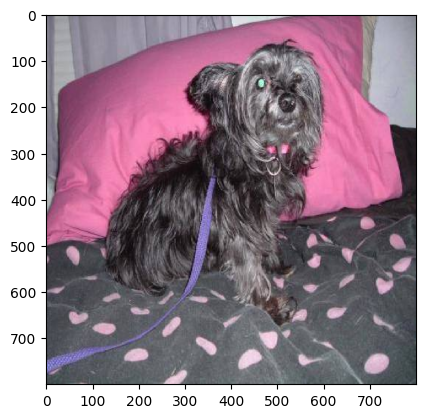

In [14]:
img_pre = load_img("dog.0.jpg",target_size=(800,800))
img_pre = img_to_array(img_pre)
img_pre = np.divide(img_pre,255.0)
plt.imshow(img_pre)
img_pre = np.expand_dims(img_pre,axis=0)

feature_map = vgg_16_backbone.call(img_pre)

ValueError: num must be an integer with 1 <= num <= 56, not 57

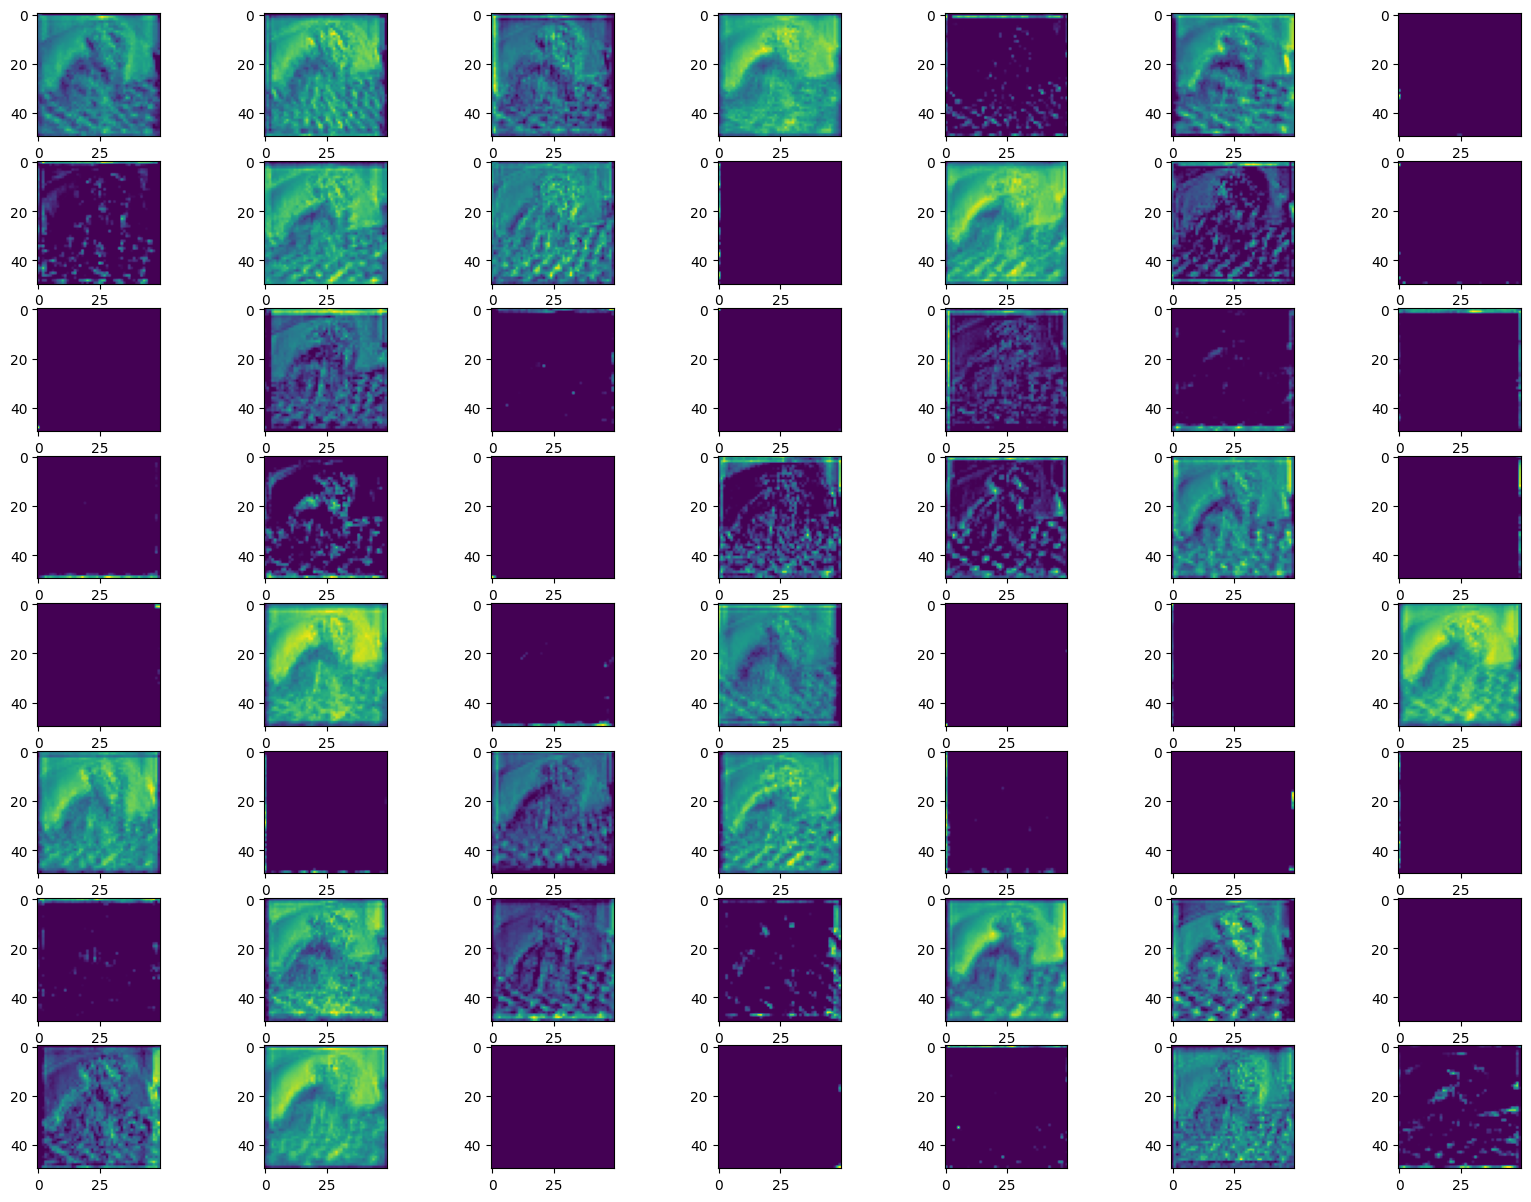

In [29]:
fig=plt.figure(figsize=(20,15))
for index in range(1,feature_map.shape[3]+1):
  plt.subplot(8,7,index)
  plt.imshow(feature_map[0,:,:,index-1])

plt.show()

In [15]:
image_width,image_height,_ = training_set[0][0][0].shape

In [16]:
print(f'Image Width: {image_width}, Image Height: {image_height}')

Image Width: 800, Image Height: 800


# Creating Components Of Faster RCNN

## 1. Implementing Anchors To Be Placed On Image

In [17]:
def get_number_of_anchors(img):
  _,axis_1,axis_2,_ = img.shape
  anchors= axis_1 * axis_2
  return anchors,axis_1,axis_2

In [18]:
number_of_anchors,x_axis,y_axis = get_number_of_anchors(img)

In [19]:
print(number_of_anchors)

2500


In [20]:
def calculate_anchor_stride(original_image_width=800,original_image_height=800,feature_map_axis_1=None,feature_map_axis_2=None):
  anchor_stride_x = int(original_image_width/feature_map_axis_1)
  anchor_stride_y = int(original_image_height/feature_map_axis_2)
  
  return anchor_stride_x,anchor_stride_y

anchor_stride_x ,anchor_stride_y = calculate_anchor_stride(800,800,x_axis,y_axis)

print(f'Anchor X Stride: {anchor_stride_x}, Anchor Y Stride: {anchor_stride_y}')

Anchor X Stride: 16, Anchor Y Stride: 16


In [22]:
def create_anchor_centers_array(image_width=800,image_height=800,anchor_stride_x=None,anchor_stride_y=None,width_scale_factor=None,height_scale_factor=None):
  anchors_X_center = np.arange(anchor_stride_x/2,image_width,anchor_stride_x)/width_scale_factor
  anchors_Y_center = np.arange(anchor_stride_y/2,image_height,anchor_stride_y)/height_scale_factor

  return anchors_X_center,anchors_Y_center

anchors_X_center, anchors_Y_center = create_anchor_centers_array(800,800,50,50,anchor_stride_x,anchor_stride_y)

print(anchors_X_center)
print(anchors_Y_center)

[ 1.5625  4.6875  7.8125 10.9375 14.0625 17.1875 20.3125 23.4375 26.5625
 29.6875 32.8125 35.9375 39.0625 42.1875 45.3125 48.4375]
[ 1.5625  4.6875  7.8125 10.9375 14.0625 17.1875 20.3125 23.4375 26.5625
 29.6875 32.8125 35.9375 39.0625 42.1875 45.3125 48.4375]


In [23]:
def create_center_grid(anchors_X_center,anchors_Y_center):
  anchor_center_coord = np.array(np.meshgrid(anchors_X_center,anchors_Y_center,sparse=False,indexing='xy')).T.reshape(-1,2)
  return anchor_center_coord
anchor_center_coord = create_center_grid(anchors_X_center*anchor_stride_x,anchors_Y_center*anchor_stride_y)
print(anchor_center_coord)

[[ 25.  25.]
 [ 25.  75.]
 [ 25. 125.]
 [ 25. 175.]
 [ 25. 225.]
 [ 25. 275.]
 [ 25. 325.]
 [ 25. 375.]
 [ 25. 425.]
 [ 25. 475.]
 [ 25. 525.]
 [ 25. 575.]
 [ 25. 625.]
 [ 25. 675.]
 [ 25. 725.]
 [ 25. 775.]
 [ 75.  25.]
 [ 75.  75.]
 [ 75. 125.]
 [ 75. 175.]
 [ 75. 225.]
 [ 75. 275.]
 [ 75. 325.]
 [ 75. 375.]
 [ 75. 425.]
 [ 75. 475.]
 [ 75. 525.]
 [ 75. 575.]
 [ 75. 625.]
 [ 75. 675.]
 [ 75. 725.]
 [ 75. 775.]
 [125.  25.]
 [125.  75.]
 [125. 125.]
 [125. 175.]
 [125. 225.]
 [125. 275.]
 [125. 325.]
 [125. 375.]
 [125. 425.]
 [125. 475.]
 [125. 525.]
 [125. 575.]
 [125. 625.]
 [125. 675.]
 [125. 725.]
 [125. 775.]
 [175.  25.]
 [175.  75.]
 [175. 125.]
 [175. 175.]
 [175. 225.]
 [175. 275.]
 [175. 325.]
 [175. 375.]
 [175. 425.]
 [175. 475.]
 [175. 525.]
 [175. 575.]
 [175. 625.]
 [175. 675.]
 [175. 725.]
 [175. 775.]
 [225.  25.]
 [225.  75.]
 [225. 125.]
 [225. 175.]
 [225. 225.]
 [225. 275.]
 [225. 325.]
 [225. 375.]
 [225. 425.]
 [225. 475.]
 [225. 525.]
 [225. 575.]
 [225. 625.]

In [25]:
def display_center_grid(img,anchor_center_coord,number_of_anchors):
  img_copy = np.copy(img)

  for i in range(len(anchor_center_coord)):
    cv.circle(img_copy,(int(anchor_center_coord[i][0]),int(anchor_center_coord[i][1])),radius=1,color=(255,0,0),thickness=5)
  
  return img_copy

plt.imshow(display_center_grid(training_set[0][0][0],anchor_center_coord,number_of_anchors))

TypeError: Circle.__init__() got multiple values for argument 'radius'

In [ ]:
def create_anchor_boxes(x1,y1,x2,y2,img):
  img_box = cv.rectangle(img,(x1,y1),(x2,y2),(255,0,0),1)
  return img_box

In [ ]:
plt.imshow(create_anchor_boxes(200,200,600,600,training_set[0][0][0]))

In [ ]:
base_anchor_box = [128,128]
anchor_box_ratio=[0.5,1,1.5]
anchor_box_scales = [1,2,3]
def create_aspect_boxes(anchor_box_ratio,anchor_box_scales):
    # for ratios in anchor_box_ratio:
  #   for scales in anchor_box_scales:
  #     scaled_box = [base_anchor_box[0]*scales,base_anchor_box[1]*scales]
  #     if ratios < 1:
  #       aspect_box.append([scaled_box[0],scaled_box[1]/ratios])
  #     else:
  #       aspect_box.append([scaled_box[0]*ratios,scaled_box[1]])
  aspect_ratio_box = []
  scale_box = []
  for ratios in anchor_box_ratio:
    aspect_ratio_box.append([base_anchor_box[0],base_anchor_box[1]/ratios])
  for scales in anchor_box_scales:
    for ratios in aspect_ratio_box:
      scale_box.append([ratios[0]*scales,ratios[1]*scales])

  return scale_box

In [ ]:
def relative_coordinates(aspect_boxes,x_c,y_c):
  final_box=[]
  for boxes in aspect_boxes:
    width_alignment = boxes[0]/2
    height_alignment = boxes[1]/2
    final_box.append([x_c-height_alignment,y_c-width_alignment,x_c+height_alignment,y_c+width_alignment])
  return final_box

In [ ]:
def create_relative_anchor_boxes(pixel_boxes,img):
  for coordinates in pixel_boxes:
    for boxes in coordinates:
      x1=int(boxes[0])
      y1=int(boxes[1])
      x2 = int(boxes[2])
      y2 = int(boxes[3])
      img = create_anchor_boxes(x1,y1,x2,y2,img)
  return img

In [ ]:
grid_image = display_center_grid(training_set[0][0][0],anchor_center_coord,number_of_anchors)
aspect_box = create_aspect_boxes(anchor_box_ratio,anchor_box_scales)
pixel_boxes = []
for coordinates in anchor_center_coord:
  pixel_boxes.append(relative_coordinates(aspect_box,coordinates[0],coordinates[1]))

plt.imshow(create_relative_anchor_boxes(pixel_boxes,grid_image))

In [ ]:
fm_test = feature_map[0,:,:,5]
print(feature_map.shape)
print(fm_test.shape)
plt.imshow(fm_test)

In [ ]:
feature_map_center = create_center_grid(anchors_X_center,anchors_Y_center)

In [ ]:
# aspect_box = create_aspect_boxes(anchor_box_ratio,anchor_box_scales)
# pixel_boxes = []
# for coordinates in feature_map_center:
#   pixel_boxes.append(relative_coordinates(aspect_box,coordinates[0],coordinates[1]))

def calculate_anchor_grid(feature_map_anchor_centers,anchor_box_ratio,anchor_box_scales):
  multi_scale_ratio_anchor_boxes = create_aspect_boxes(anchor_box_ratio,anchor_box_scales)
  pxiel_boxes = []
  for coordinates in feature_map_anchor_centers:
    pixel_boxes.append(relative_coordinates(multi_scale_ratio_anchor_boxes,coordinates[0],coordinates[1]))
  return pixel_boxes

grid = calculate_anchor_grid(anchor_center_coord,anchor_box_ratio,anchor_box_scales)
plt.imshow(create_relative_anchor_boxes(grid,training_set[0][0][0]))
print(grid)

In [ ]:
img_resized = cv.resize(training_set[0][0][0],(50,50),cv.INTER_AREA)

In [ ]:
plt.imshow(img_resized)

In [ ]:
grid = calculate_anchor_grid(feature_map_center,anchor_box_ratio,anchor_box_scales)
print(grid)
plt.imshow(create_relative_anchor_boxes(grid,img_resized))

In [ ]:
def create_anchor_boxes_for_feature_map(img):
  number_of_anchors,x_axis,y_axis = get_number_of_anchors(img)
  anchor_stride_x ,anchor_stride_y = calculate_anchor_stride(800,800,x_axis,y_axis)
  # print(f'Anchor X Stride: {anchor_stride_x}, Anchor Y Stride: {anchor_stride_y}')
  anchors_X_center, anchors_Y_center = create_anchor_centers_array(800,800,50,50,anchor_stride_x,anchor_stride_y)
  # print(anchors_X_center)
  # print(anchors_Y_center)
  anchor_center_coord = create_center_grid(anchors_X_center,anchors_Y_center)
  # plt.imshow(display_center_grid(training_set[0][0][1],anchor_center_coord,number_of_anchors))
  # grid_image = display_center_grid(training_set[0][0][1],anchor_center_coord,number_of_anchors)
  aspect_box = create_aspect_boxes(anchor_box_ratio,anchor_box_scales)
  pixel_boxes = []
  for coordinates in anchor_center_coord:
    pixel_boxes.append(relative_coordinates(aspect_box,coordinates[0],coordinates[1]))
  return pixel_boxes
# plt.imshow(create_relative_anchor_boxes(pixel_boxes,grid_image))
img_resized = cv.resize(training_set[0][0][0],(50,50),cv.INTER_AREA)
feature_map_anchor = create_anchor_boxes_for_feature_map(img)
print(feature_map_anchor)
plt.imshow(create_relative_anchor_boxes(feature_map_anchor,img_resized))

In [ ]:
def create_anchor_boxes_for_image(img):
  number_of_anchors,x_axis,y_axis = get_number_of_anchors(img)
  anchor_stride_x ,anchor_stride_y = calculate_anchor_stride(800,800,x_axis,y_axis)
  # print(f'Anchor X Stride: {anchor_stride_x}, Anchor Y Stride: {anchor_stride_y}')
  anchors_X_center, anchors_Y_center = create_anchor_centers_array(800,800,50,50,anchor_stride_x,anchor_stride_y)
  # print(anchors_X_center)
  # print(anchors_Y_center)
  anchor_center_coord = create_center_grid(anchors_X_center*anchor_stride_x,anchors_Y_center*anchor_stride_y)
  # plt.imshow(display_center_grid(training_set[0][0][1],anchor_center_coord,number_of_anchors))
  # grid_image = display_center_grid(training_set[0][0][1],anchor_center_coord,number_of_anchors)
  aspect_box = create_aspect_boxes(anchor_box_ratio,anchor_box_scales)
  pixel_boxes = []
  for coordinates in anchor_center_coord:
    pixel_boxes.append(relative_coordinates(aspect_box,coordinates[0],coordinates[1]))
  return pixel_boxes

img_anchor_boxes = create_anchor_boxes_for_image(img)
print(img_anchor_boxes)
plt.imshow(create_relative_anchor_boxes(img_anchor_boxes,training_set[0][0][0]))

In [ ]:
print(base_anchor_box)
plt.imshow(create_anchor_boxes(10,10,40,40,img_resized))

In [ ]:
plt.imshow(display_center_grid(img_resized,feature_map_anchor,number_of_anchors))

In [4]:
"""
    VGG 16 Model with No Fully Connected Layers present. Used primarily as the backbone for the Mask RCNN  
"""
class VGG_16_NFCL(tf.keras.Model):
    def __init__(self):
        super(VGG_16_NFCL, self).__init__()

        # Layer 1
        self.conv_1a = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name="conv_1A")
        self.conv_1b = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', name="conv_1B")
        self.max_pool_1a = MaxPool2D(pool_size=2, strides=2, padding='same', name="max_pool1A")

        # Layer 2
        self.conv_2a = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name="conv_2A")
        self.conv_2b = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', name="conv_2B")
        self.max_pool_2a = MaxPool2D(pool_size=2, strides=2, padding='same', name="max_pool2A")

        # Layer 3
        self.conv_3a = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name="conv_3A")
        self.conv_3b = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name="conv_3B")
        self.conv_3c = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', name="feature_map_1")
        self.max_pool_3a = MaxPool2D(pool_size=2, strides=2, padding='same', name="max_pool3A")

        # Layer 4
        self.conv_4a = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="conv_4A")
        self.conv_4b = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="conv_4B")
        self.conv_4c = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="feature_map_2")
        self.max_pool_4a = MaxPool2D(pool_size=2, strides=2, padding='same', name="max_pool4A")

        # Layer 5
        self.conv_5a = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="conv_5A")
        self.conv_5b = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="conv_5B")
        self.conv_5c = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name="feature_map_3")

    def call(self, input_tensor, training=False, mask=None):
        x = self.conv_1a(input_tensor)
        x = self.conv_1b(x)
        x = self.max_pool_1a(x)

        x = self.conv_2a(x)
        x = self.conv_2b(x)
        x = self.max_pool_2a(x)

        x = self.conv_3a(x)
        x = self.conv_3b(x)
        x = self.conv_3c(x)
        x = self.max_pool_3a(x)

        x = self.conv_4a(x)
        x = self.conv_4b(x)
        x = self.conv_4c(x)
        x = self.max_pool_4a(x)

        x = self.conv_5a(x)
        x = self.conv_5b(x)
        x = self.conv_5c(x)

        return x

    def build_graph(self,input_size):
        x = tf.keras.layers.Input(shape=(input_size[0],input_size[1],3))
        return tf.keras.Model(inputs=[x],outputs=self.call(x))

    def build(self,input_shape):
        super().build(input_shape)
        self.load_weights('/content/drive/MyDrive/Colab_Notebooks/Faster RCNN/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [5]:
training_gen = ImageDataGenerator(rescale=1.0 / 255.0)
training_set = training_gen.flow_from_directory('/content/drive/MyDrive/Colab_Notebooks/Faster RCNN/Cats vs Dogs/Test', target_size=(800, 800),batch_size=2)
vgg_16_backbone = VGG_16_NFCL()
# img_pre = load_img("/content/drive/MyDrive/Colab_Notebooks/Faster RCNN/dog.0.jpg",target_size=(800,800))
# img_pre = img_to_array(img_pre)
# img_pre = np.divide(img_pre,255.0)
# plt.imshow(img_pre)
# img_pre = np.expand_dims(img_pre,axis=0)

img = vgg_16_backbone.call(training_set[0][0])

Found 140 images belonging to 2 classes.


In [45]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Activation, Add, ZeroPadding2D, AveragePooling2D, Dense
import math

def get_number_of_anchors(feature_map) -> (int, int, int):
    """
    Calculates the number of anchors for the the feature_map

    Parameters
    ----------
    feature_map: Feature Map created by CNN backbone
    ----------

    Returns
    ----------
    (int, int, int)
        Tuple of the Number of anchors, the X-axis size of the feature map, the Y-axis size of the feature map
    ----------
    """
    # Get the Shape of the Image (WxH)
    _, axis_1, axis_2, _ = feature_map.shape
    # Total Number of Anchor Points Possible is WxH
    anchors = axis_1 * axis_2
    # Return Tuple of Number of Anchors, Axis Sizes
    return anchors, axis_1, axis_2


def calculate_anchor_stride(original_image_width=800, original_image_height=800, feature_map_axis_1=None
                            , feature_map_axis_2=None) -> (int, int):
    """
    Calculates the anchor stride for the feature map

    Parameters
    ----------
    original_image_width: Width of the input image
    original_image_height: Height of the input image
    feature_map_axis_1: Size of the feature map X-axis
    feature_map_axis_2: Size of the feature map Y-axis
    ----------

    Returns
    ----------
    (int, int)
        Tuple of anchor stride X-axis and Y-axis
    ----------
    """
    # Calculating Stride for feature map on the original image x-axis
    anchor_stride_x = int(original_image_width / feature_map_axis_1)
    # Calculating Stride for feature map on the original image y-axis
    anchor_stride_y = int(original_image_height / feature_map_axis_2)

    return anchor_stride_x, anchor_stride_y


def create_anchor_centers_array(image_width, image_height, anchor_stride_x, anchor_stride_y) -> (np.array, np.array):
    """
    Calculates the anchor centers

    Parameters
    ----------
    image_width: Width of the input image
    image_height: Height of the input image
    anchor_stride_x: Stride of the anchors on the X-axis
    anchor_stride_y: Stride of the anchors on the Y-axis
    ----------

    Returns
    ----------
    (np.array,np.array)
        Tuple of the ranges for the the anchor positions on the X-axis and Y-axis
    ----------
    """

    # Creating an array of number of x-axis anchor intervals
    anchors_x_center = np.arange(8, image_width, anchor_stride_x) / anchor_stride_x
    # Creating an array of number of y-axis anchor intervals
    anchors_y_center = np.arange(8, image_height, anchor_stride_y) / anchor_stride_y

    return anchors_x_center, anchors_y_center


def create_center_grid(anchors_x_center, anchors_y_center) -> np.array:
    """
    Creates a grid of the anchor points for the image

    Parameters
    ----------
    anchors_x_center: X coordinate of the anchor centers
    anchors_y_center: Y coordinate of the anchor centers
    ----------

    Returns
    ----------
    anchor_center_coord
        Grid of the anchor points
    ----------
    """

    # Creating a 2D Numpy Array of the Anchor Position over the coordinate Axes over the Image
    anchor_center_coord = np.array(
        np.meshgrid(anchors_x_center, anchors_y_center, sparse=False, indexing='xy')).T.reshape(-1, 2)

    return anchor_center_coord


def display_center_grid(img, anchor_center_coord, number_of_anchors) -> np.array:
    """
    Creates a grid of the anchor points for the image

    Parameters
    ----------
    img: Input Image
    anchor_center_coord: Array of anchor centers
    number_of_anchors: Number of anchors for the Image
    ----------

    Returns
    ----------
    img_copy
        Image copy that has the bounding box created over it
    ----------
    """

    # Copy of the input image to be manipulated
    img_copy = np.copy(img)

    # Iterate over the image and create the anchor coordinate grid
    for i in range(number_of_anchors):
        cv.circle(img_copy, (int(anchor_center_coord[i][0]), int(anchor_center_coord[i][1])), radius=1,
                  color=(255, 0, 0), thickness=2)

    # Image with Anchor Grid
    return img_copy


def create_anchor_boxes(x1, y1, x2, y2, img, colour) -> np.array:
    """
    Creates a grid of the anchor points for the image

    Parameters
    ----------
    x1: X-coordinate of Top Left Corner
    y1: Y-coordinate of Top Left Corner
    x2: X-coordinate of Bottom Right Corner
    y2: Y-coordinate of Bottom Right Corner
    colour: Color for the anchor boxes
    ----------

    Returns
    ----------
    img_box
        Image with anchor box
    ----------
    """
    # Creating the bounding box centered over a pixel
    img_box = cv.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
    # Image with bounding box
    return img_box


def create_aspect_boxes(anchor_box_ratio, anchor_box_scales, base_anchor_box) -> []:
    """
    Creates a grid of the anchor points for the image

    Parameters
    ----------
    anchor_box_ratio: Different aspect ratios used for the bounding boxes
    anchor_box_scales: Different scale ratios used for the bounding boxes
    base_anchor_box: Base anchor box size
    ----------

    Returns
    ----------
    aspect_box
        List of aspect boxes with different scales and aspect ratios for each anchor point
    ----------
    """

    aspect_box = []
    # Iterate Over the ratios and scales and transform the bounding box dimensions.
    for ratios in anchor_box_ratio:
        for scales in anchor_box_scales:
            scaled_box = [base_anchor_box[0] * scales, base_anchor_box[1] * scales]
            if ratios < 1:
                aspect_box.append([scaled_box[0], scaled_box[1] / ratios])
            else:
                aspect_box.append([scaled_box[0] * ratios, scaled_box[1]])
    return aspect_box


def relative_coordinates(aspect_boxes, x_c, y_c):
    """
    Creates a grid of the anchor points for the image

    Parameters
    ----------
    aspect_boxes: Array of bounding boxes with different aspect ratios and scales
    x_c: X center of the anchor
    y_c: Y center of the anchor
    ----------

    Returns
    ----------
    final_box
        List of anchor boxes for each anchor point
    ----------
    """
    final_box = []
    # Iterate over the transformed boxes and create coordinate relative to the center pixel.
    for boxes in aspect_boxes:
        width_alignment = boxes[0] / 2
        height_alignment = boxes[1] / 2
        final_box.append([x_c - width_alignment, y_c - height_alignment, x_c + width_alignment, y_c + height_alignment])
    # Array of bounding boxes relative to the pixel
    return final_box


def create_relative_anchor_boxes(image_tensor, img, colour):
    """
    Creates a grid of the anchor points for the image

    Parameters
    ----------
    image_tensor: Tensor with the image Anchor box
    img: Input Image
    colour: Color of the bounding box
    ----------

    Returns
    ----------
    None
    ----------
    """
    """
    
    """
    image_tensor = image_tensor.numpy()
    for coordinates in image_tensor:
            x1 = int(coordinates[0])
            y1 = int(coordinates[1])
            x2 = int(coordinates[2])
            y2 = int(coordinates[3])
            img = create_anchor_boxes(x1, y1, x2, y2, img, (255, 0, 0))
        # Image with multiple bounding boxes over a central pixel
    return img


#todo: Test IoU Score List

def check_rectangle_overlap(ground_truth_box, image_tensor,batch_size, sort_iou=False):
    """
    Parameters
    ----------
    ground_truth_box: Ground truth box for the image
    image_tensor: Image tensor
    sort_iou: Option to return sorted IoU scores
    ----------

    Returns
    ----------
    iou_score_list
        An array of IoU scores and the associated anchor boxes
    ----------
    """
    iou_matrix_tensor = tf.Variable(tf.zeros((image_tensor.shape[0],len(ground_truth_box),image_tensor.shape[1])))
    for batch in range(batch_size):
      for gt_index in range(len(ground_truth_box)):
          gt_box = ground_truth_box[gt_index]
          iou_score_list = []
          for boxes in image_tensor[batch].numpy():
              # img = cv.rectangle(img, (boxes[0], boxes[1]), (boxes[2], boxes[3]), (0, 255, 0), 3)
              if (gt_box[0] <= boxes[2] and gt_box[2] >= boxes[0] and
                   gt_box[1] <= boxes[3] and gt_box[3] >= boxes[1]):
                # print("Intersection")
                  area_of_intersection = get_intersection_area(gt_box, boxes)
                  rectangle_area_1, rectangle_area_2 = get_union_area(gt_box, boxes)
                  iou_score = area_of_intersection / (rectangle_area_2 + rectangle_area_1 - area_of_intersection)
              else:
                # print("No Intersection")
                iou_score = 0
          
              iou_score_list.append(iou_score)
          iou_matrix_tensor[batch,gt_index].assign(iou_score_list)

        
    # plt.imshow(img)
    # plt.show()

    if sort_iou:
        # iou_score_list = sorted(iou_score_list, key=lambda x: x, reverse=True)
        pass

    return tf.transpose(iou_matrix_tensor, perm=[0, 2, 1])
    # print(f'Area of Intersection: {area_of_intersection}, Area of Union: {rectangle_area_1}, {rectangle_area_2}')
    # print(f'IOU Score: {iou_score}')
    # return img


def get_intersection_area(bounding_box_1, bounding_box_2) -> float:
    """
    Parameters
    ----------
    bounding_box_1: Array of coordinates for bounding box
    bounding_box_2: Array of coordinates for bounding box
    ----------

    Returns
    ----------
    Area of Intersection
    ----------
    """
    x1 = max(bounding_box_1[0], bounding_box_2[0])
    y1 = max(bounding_box_1[1], bounding_box_2[1])
    x2 = min(bounding_box_1[2], bounding_box_2[2])
    y2 = min(bounding_box_1[3], bounding_box_2[3])

    return (x2 - x1) * (y2 - y1)


def get_union_area(bounding_box_1, bounding_box_2):
    """
    Parameters
    ----------
    bounding_box_1: Array of coordinates for bounding box
    bounding_box_2: Array of coordinates for bounding box
    ----------

    Returns
    ----------
    Area of Bounding Box, Area of Bounding Box
        Tuple made of multiple bounding box area
    ----------
    """
    area_rectangle_1 = (bounding_box_1[2] - bounding_box_1[0]) * (bounding_box_1[3] - bounding_box_1[1])
    area_rectangle_2 = (bounding_box_2[2] - bounding_box_2[0]) * (bounding_box_2[3] - bounding_box_2[1])

    return area_rectangle_1, area_rectangle_2
  
def convert_to_anchor_box_coordinates(index):
    """
    Parameters
    ----------
    index: Index from one score from the ground truth box in the IOU Matrix
    ----------

    Returns
    ----------
    Row and Coordinates of the corresponding anchor box for the IOU Score
    ----------
    """
    row = math.floor(index / 9)
    column = index % 9

    return (row,column)
#########################################################################################################################
##todo: IMPORTANT: CLIP OUT OF BOUNDS BOUNDING BOXES
class Region_Proposal_Network(tf.keras.Model):
    def __init__(self, filters, kernel_size,batch_size):
        super(Region_Proposal_Network, self).__init__()

        # Region Proposal Network Layers
        self.rpn_conv = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')
        self.reg_conv = None
        self.cls_conv = None

        # Model Util Variables
        self.base_box_image = [128, 128]
        self.base_box_feature_map = [int(128 / 16), int(128 / 16)]
        self.image_anchors_centers_grid = list()
        self.feature_map_anchors_centers_grid = list()
        self.image_relative_anchor_boxes = list()
        self.feature_map_relative_anchor_boxes = list()
        self.anchor_box_aspect_ratio = [0.5, 1, 1.5]
        self.anchor_box_scales = [1, 2, 3]
        self.scale_factor = list()
        self.number_of_anchors = 0
        self.ground_truth_box = [[0/16,0/16,500/16,500/16],[200/16, 200/16, 600/16, 600/16],[300/16, 300/16, 500/16, 500/16],]
        self.iou_scores = []
        self.positive_anchor_threshold = 0.7
        self.negative_threshold = 0.3
        # self.batch_size = batch_size
        # self.initialize_hyper_parameters()


    def call(self, input_feature_map, training=False, mask=None):
        x = self.rpn_conv(input_feature_map)

        reg = self.reg_conv(x)

        cls = self.cls_conv(x)

        self.intersection_over_union_scores(True)

        cls_transpose = tf.transpose(cls,perm=[0,3,1,2])

        avg_obj_scores = tf.reduce_max(cls_transpose,axis=[2,3])

        scored_anchor_boxes = tf.concat([self.feature_map_relative_anchor_boxes,tf.expand_dims(avg_obj_scores,axis=-1)],axis=-1)
        

        # scored_anchor_boxes = tf.reshape(scored_anchor_boxes,[-1,22500*50*50,5])

        # temp_tensor = scored_anchor_boxes[:,:,-1] > 0.5

        # ragged_tensor = []

        # for batch in range(scored_anchor_boxes.shape[0]):
        #   values = scored_anchor_boxes[batch][temp_tensor[batch]]
        #   ragged_tensor.append(tf.RaggedTensor.from_tensor(values))

        # ragged_tensor = tf.stack(ragged_tensor)

        # nms_regions = self.non_max_suppression(ragged_tensor.to_tensor(),0.7) 

        return [cls_transpose,reg]

    def inference(self):
        # temp_tensor = scored_anchor_boxes[:,:,-1] > 0.5
        # ragged_tensor = []
        # for batch in range(scored_anchor_boxes.shape[0]):
        #     values = scored_anchor_boxes[batch][temp_tensor[batch]]
        #     ragged_tensor.append(tf.RaggedTensor.from_tensor(values))
        # ragged_tensor = tf.stack(ragged_tensor)

        # nms_regions = self.non_max_suppression(ragged_tensor.to_tensor(),0.7)
        pass

    def build_graph(self, input_shape) -> tf.keras.Model:
        """
        Builds the Graph for the Faster R-CNN Model

        Parameters
        ----------
        input_shape: Expected Shape of the Input Tensor
        ----------

        Returns
        ----------
        Model
            A Tensorflow Model showing the inputs and outputs of multiple layers
        """
        # Cretes a example tensor for the model to create the graph for the Faster R-CNN Model.
        x = tf.keras.Input(shape=(input_shape[0], input_shape[1], 512))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

    def initialize_hyper_parameters(self,feature_map):
        self.batch_size = feature_map.shape[0]
        self.calculate_scale_factor(feature_map)
        self.calculate_anchor_grid()
        self.calculate_relative_anchor_boxes()
        self.cls_conv = Conv2D(filters=self.number_of_anchors*9, kernel_size=(1,1), activation='sigmoid', padding='same')
        self.reg_conv = Conv2D(filters=self.number_of_anchors*9*4, kernel_size=(1,1), activation='linear', padding='same')

    def calculate_scale_factor(self, feature_map) -> None:
        """
        Calculates the Scale factor between the feature map and the original image

        Parameters
        ----------
        feature_map: The feature map created by the CNN backbone.
        ----------

        Returns
        ----------
        None
        """
        # assert (feature_map is None), "ERROR: Feature Map is None"

        # Gets the number of anchors, the size of the x and y axes in the feature map
        self.number_of_anchors, feature_map_axis_1, feature_map_axis_2 = get_number_of_anchors(feature_map)
        # Gets the x and y strides for the anchor points
        x_scale, y_scale = calculate_anchor_stride(800, 800, feature_map_axis_1, feature_map_axis_2)

        self.scale_factor.append(x_scale)
        self.scale_factor.append(y_scale)

    def calculate_anchor_grid(self, image_width=800, image_height=800) -> None:
        """
        Calculate the anchor grid for the feature map and image separately

        Parameters
        ----------
        image_width: Width of the Input Image (Default Value = 800)
        image_height: Height of the Input Image (Default Value = 800)
        ----------

        Returns
        ----------
        None
        """

        # Calculates the X and Y centers for each anchor point
        anchor_X_centers, anchor_Y_centers = create_anchor_centers_array(image_width, image_height,
                                                                         anchor_stride_x=self.scale_factor[0],
                                                                         anchor_stride_y=self.scale_factor[1])
        # Calculates the anchor grid for the image as well as the feature map separately
        self.feature_map_anchors_centers_grid = create_center_grid(anchor_X_centers, anchor_Y_centers)
        self.image_anchors_centers_grid = create_center_grid(anchor_X_centers * self.scale_factor[0],
                                                             anchor_Y_centers * self.scale_factor[1])

    def calculate_relative_anchor_boxes_image(self):
        """
        Calculates the image relative anchor boxes for each anchor center
        Parameters
        ----------

        ----------

        Returns
        ----------
        [[[float]]]
            List of final anchor boxes by using relative coordinates for the image
        """
        anchor_box_tensor = tf.Variable(tf.zeros((self.batch_size,self.number_of_anchors*len(self.anchor_box_aspect_ratio)*len(self.anchor_box_scales),4)))
        # Creates the various boxes for different aspect ratios and scales for the model
        different_aspect_boxes = create_aspect_boxes(anchor_box_ratio=self.anchor_box_aspect_ratio,
                                                     anchor_box_scales=self.anchor_box_scales,
                                                     base_anchor_box=self.base_box_image)
        final_anchor_boxes = []
        # Iterates over the coordinates in the center and calculates the relative coordinate for each anchor point
        for coordinates in self.image_anchors_centers_grid:
            final_anchor_boxes.append(relative_coordinates(different_aspect_boxes, coordinates[0], coordinates[1]))

        final_anchor_boxes = [item for sublist in final_anchor_boxes for item in sublist]

        for i in range(self.batch_size):
          anchor_box_tensor[i].assign(final_anchor_boxes)

        return anchor_box_tensor

    def calculate_relative_anchor_boxes_feature_map(self):
        """
        Calculates the  feature map relative anchor boxes for each anchor center

        Parameters
        ----------

        ---------

        Returns
        ----------
        [[[float]]]
        List of final anchor boxes by using relative coordinates for the feature_map
        """
        anchor_box_tensor = tf.Variable(tf.zeros((self.batch_size,self.number_of_anchors*len(self.anchor_box_aspect_ratio)*len(self.anchor_box_scales),4)))
        # Creates the various boxes for different aspect ratios and scales for the model
        different_aspect_boxes = create_aspect_boxes(anchor_box_ratio=self.anchor_box_aspect_ratio,
                                                     anchor_box_scales=self.anchor_box_scales,
                                                     base_anchor_box=self.base_box_feature_map)
        final_anchor_boxes = []
        # Iterates over the coordinates in the center and calculates the relative coordinate for each anchor point
        for coordinates in self.feature_map_anchors_centers_grid:
            final_anchor_boxes.append(relative_coordinates(different_aspect_boxes, coordinates[0], coordinates[1]))

        final_anchor_boxes = [item for sublist in final_anchor_boxes for item in sublist]
        for i in range(self.batch_size):
          anchor_box_tensor[i].assign(final_anchor_boxes)


        return anchor_box_tensor

    def calculate_relative_anchor_boxes(self) -> None:
        """
        The function calculates the relative anchor boxes for each anchor point for both the image
        and feature map

        Parameters
        ----------

        ----------

        Returns
        ----------
        None
        ----------
        """
        # Calculates the relative anchor boxes for the image as well as the feature map separately
        self.image_relative_anchor_boxes = self.calculate_relative_anchor_boxes_image()
        self.feature_map_relative_anchor_boxes = self.calculate_relative_anchor_boxes_feature_map()

    def intersection_over_union_scores(self,sort_iou=False):

        """
        Parameters
        ----------
        ground_truth_box: Ground truth box for the image
        anchor_boxes: Array of anchor boxes
        sort_iou: Option to return sorted IoU scores
        ----------

        Returns
        ----------
        iou_score_list
            An array of IoU scores and the associated anchor boxes
        ----------
        """
        iou_score = []

        self.iou_scores = check_rectangle_overlap(ground_truth_box=self.ground_truth_box,image_tensor=self.feature_map_relative_anchor_boxes,sort_iou=True,batch_size=self.batch_size)
        
        # self.iou_scores = np.transpose(iou_score)

    def get_max_value_from_iou_scores(self):
        max_iou_scores = tf.math.reduce_max(self.iou_scores,axis=0,keepdims=True)
        max_iou_indices = tf.argmax(self.iou_scores, axis=0)

        return max_iou_scores,max_iou_indices

    def get_positive_iou_scores(self):
      pass

   # Based on the NMS function from https://github.com/rbgirshick/fast-rcnn/blob/master/lib/utils/nms.py

    def non_max_suppression(self,image_scored_anchor_tensor,nms_thresh):
      proposal_regions = []
      for batch in range(image_scored_anchor_tensor.shape[0]):
          x1 = image_scored_anchor_tensor[batch,:, 0]
          y1 = image_scored_anchor_tensor[batch,:, 1]
          x2 = image_scored_anchor_tensor[batch,:, 2]
          y2 = image_scored_anchor_tensor[batch,:, 3]
          scores = image_scored_anchor_tensor[batch,:, 4]

          areas = (x2 - x1 + 1) * (y2 - y1 + 1)
          order = tf.argsort(scores,direction="DESCENDING")

          keep = []
          while len(order) > 0:
            i = order[0]
            keep.append(i)
            xx1 = tf.maximum(x1[i], tf.gather(x1,order[1:]))
            yy1 = tf.maximum(y1[i], tf.gather(y1,order[1:]))
            xx2 = tf.minimum(x2[i], tf.gather(x2,order[1:]))
            yy2 = tf.minimum(y2[i], tf.gather(y2,order[1:]))

            w = tf.maximum(0.0, xx2 - xx1 + 1)
            h = tf.maximum(0.0, yy2 - yy1 + 1)
            inter = w * h
            ovr = inter / (areas[i] + tf.gather(areas,order[1:]) - inter)

            inds = tf.squeeze(tf.where(ovr <= nms_thresh),axis=-1)
            order = tf.gather(order,inds + 1)

          proposal_regions.append(tf.RaggedTensor.from_tensor(tf.gather(image_scored_anchor_tensor[batch],keep)))
      
    # max_dimension = tf.reduce_max([tensor.shape[0] for tensor in proposal_regions])

    # padded_tensor = [tf.keras.preprocessing.sequence.pad_sequences([tensor],maxlen=max_dimension,padding='post').squeeze() for tensor in proposal_regions]
    # stacked_tensor = tf.stack(padded_tensor,axis=0)

      return tf.stack(proposal_regions)

In [46]:
rpn = Region_Proposal_Network(filters=[512,9,6],kernel_size=[3,1,1],batch_size=4)
rpn.initialize_hyper_parameters(img)

In [47]:
print(img.shape)

(2, 50, 50, 512)


In [ ]:
# rpn.calculate_scale_factor(feature_map=img)

In [ ]:
rpn.scale_factor

ListWrapper([16, 16])

In [ ]:
rpn.calculate_anchor_grid()

In [ ]:
rpn.feature_map_anchors_centers_grid

array([[ 0.5,  0.5],
       [ 0.5,  1.5],
       [ 0.5,  2.5],
       ...,
       [49.5, 47.5],
       [49.5, 48.5],
       [49.5, 49.5]])

In [ ]:
rpn.base_box_image

ListWrapper([128, 128])

In [ ]:
rpn.base_box_feature_map

ListWrapper([8, 8])

In [ ]:
different_aspect_boxes = create_aspect_boxes(anchor_box_ratio=rpn.anchor_box_aspect_ratio,
                                                     anchor_box_scales=rpn.anchor_box_scales,base_anchor_box = rpn.base_box_image)
print(different_aspect_boxes)

[[128, 256.0], [256, 512.0], [384, 768.0], [128, 128], [256, 256], [384, 384], [192.0, 128], [384.0, 256], [576.0, 384]]


In [ ]:
anchor_tensor = rpn.calculate_relative_anchor_boxes_image()
print(anchor_tensor.shape)
print(anchor_tensor[0])

(2, 22500, 4)
tf.Tensor(
[[ -56. -120.   72.  136.]
 [-120. -248.  136.  264.]
 [-184. -376.  200.  392.]
 ...
 [ 696.  728.  888.  856.]
 [ 600.  664.  984.  920.]
 [ 504.  600. 1080.  984.]], shape=(22500, 4), dtype=float32)


In [ ]:
rpn.calculate_relative_anchor_boxes()

In [ ]:
print(rpn.image_anchors_centers_grid[1270])
rpn.image_relative_anchor_boxes[0][1270]
rpn.image_relative_anchor_boxes.shape

[408. 328.]


TensorShape([2, 22500, 4])

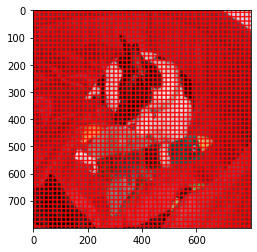

In [ ]:
plt.imshow(create_relative_anchor_boxes(rpn.image_relative_anchor_boxes[0],training_set[0][0][0],colour=(255,0,0)))

In [ ]:
img_resized = cv.resize(training_set[0][0][0],(50,50),cv.INTER_AREA)

tf.Tensor([  8. 472. 136. 600.], shape=(4,), dtype=float32)


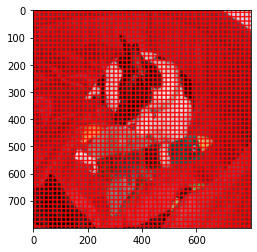

In [ ]:
bbox = rpn.image_relative_anchor_boxes[0][2100]
print(bbox)
img_trial = training_set[0][0][0]
for coordinates in rpn.image_relative_anchor_boxes[0].numpy():
  img_trial = create_anchor_boxes(int(coordinates[0]),int(coordinates[1]),int(coordinates[2]),int(coordinates[3]),img_trial,colour=(0,255,0))
plt.imshow(img_trial)

In [ ]:
rpn.intersection_over_union_scores(sort_iou=True)
# iou_score_list = check_rectangle_overlap([200,200,600,600],[[300,300,600,600],[0,0,200,200],[0,0,700,700]],sort_iou=True)
# print(iou_score_list)

In [ ]:
rpn.iou_scores

<tf.Tensor: shape=(2, 22500, 3), dtype=float32, numpy=
array([[[0.03587129, 0.        , 0.        ],
        [0.10401891, 0.        , 0.        ],
        [0.1680557 , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.03587129, 0.        , 0.        ],
        [0.10401891, 0.        , 0.        ],
        [0.1680557 , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]]], dtype=float32)>

In [ ]:
# max_index = rpn.get_max_value_from_iou_scores()
# print(max_index)

In [ ]:
# r1,c1 = convert_to_anchor_box_coordinates(max_index[0][1])
# r2,c2 = convert_to_anchor_box_coordinates(max_index[1][1])

In [ ]:
# index = (rpn.iou_scores[0].index(max(rpn.iou_scores[0])))
# row,column = convert_to_anchor_box_coordinates(index)
# print(row,column)

In [ ]:
# scores = []
# for coordinates in rpn.iou_scores:
#   scores.append(coordinates[0])
# # top_box = rpn.iou_scores[0]
# # bottom_box = rpn.iou_scores[-1]
# # print(top_box[1])
# # print(bottom_box[1])
# # print(len(rpn.image_relative_anchor_boxes[0]))
# # # print(top_box[0][0])
# print(sorted(scores,key=lambda x: x,reverse=True)[0])

In [ ]:
# top_box = rpn.image_relative_anchor_boxes[r1][c1]
# bottom_box = rpn.image_relative_anchor_boxes[r2][c2]
# img = np.zeros([800, 800, 3], dtype=np.uint8)
# img.fill(255)
# img = cv.rectangle(img, (rpn.ground_truth_box[0][0], rpn.ground_truth_box[0][1]), (rpn.ground_truth_box[0][2], rpn.ground_truth_box[0][3]), (255, 0, 0), 3)
# img = cv.rectangle(img, (rpn.ground_truth_box[1][0], rpn.ground_truth_box[1][1]), (rpn.ground_truth_box[1][2], rpn.ground_truth_box[1][3]), (0, 0, 255), 3)
# img = cv.rectangle(img, (int(top_box[0]), int(top_box[1])), (int(top_box[2]), int(top_box[3])), (0, 255, 0), 3)
# img = cv.rectangle(img, (int(bottom_box[0]), int(bottom_box[1])), (int(bottom_box[2]), int(bottom_box[3])), (0, 0, 0), 3)
# # img = cv.rectangle(img, (int(bottom_box[0][0]), int(bottom_box[0][1])), (int(bottom_box[0][2]), int(bottom_box[0][3])), (0, 0, 255), 3)
# plt.imshow(img)
# plt.show()

In [ ]:
iou_score = rpn.iou_scores
rpn.iou_scores.shape

TensorShape([2, 22500, 3])

In [ ]:
def get_max_iou_per_gt_box(image_tensor):
  max_iou_tensor = tf.Variable(tf.zeros((image_tensor.shape[0],image_tensor.shape[1],1)))
  for batch in range(image_tensor.shape[0]):
    max_iou_tensor[batch].assign(tf.math.reduce_max(image_tensor[batch],axis=1,keepdims=True))
  return max_iou_tensor

In [ ]:
max_per_anchor_box = get_max_iou_per_gt_box(rpn.iou_scores)

In [ ]:
max_per_anchor_box[0]

<tf.Tensor: shape=(22500, 1), dtype=float32, numpy=
array([[0.03587129],
       [0.10401891],
       [0.1680557 ],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]], dtype=float32)>

In [ ]:
tf.argmax(rpn.iou_scores[0],axis=1)

<tf.Tensor: shape=(22500,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0])>

In [ ]:
positve_anchor_box_cond = rpn.iou_scores[0] >= 0.7
positive_values = tf.boolean_mask(rpn.iou_scores[0],positve_anchor_box_cond)
positive_anchor_box_indices = tf.where(positve_anchor_box_cond)

In [ ]:
positive_values.shape

TensorShape([40])

In [ ]:
def get_positive_anchor_boxes(image_tensor):
  max_value = (tf.boolean_mask(image_tensor[0],image_tensor[0] >= 0.7)).shape[0]
  for batch in range(image_tensor.shape[0]):
    new_val = (tf.boolean_mask(image_tensor[batch],image_tensor[batch] >= 0.7)).shape[0]
    if new_val > max_value:
      max_value = new_val
  positive_value_anchor_boxes_tensor = tf.Variable(tf.zeros((image_tensor.shape[0],max_value)))
  for batch in range(image_tensor.shape[0]):
    positive_value_anchor_boxes_tensor[batch].assign(tf.boolean_mask(image_tensor[batch],image_tensor[batch] >= 0.7))
  return positive_value_anchor_boxes_tensor

In [ ]:
positive_anc_box = get_positive_anchor_boxes(rpn.iou_scores)

In [ ]:
positive_anc_box

In [ ]:
def get_positive_anchor_box_indices(image_tensor):
  max_value = (tf.where(image_tensor[0] >= 0.7)[:,0]).shape[0]
  for batch in range(image_tensor.shape[0]):
    new_val = (tf.where(image_tensor[batch] >= 0.7)[:,0]).shape[0]
    if new_val > max_value:
      max_value = new_val
  positive_indices = tf.Variable(tf.zeros((image_tensor.shape[0],max_value),dtype='int64'))
  for batch in range(image_tensor.shape[0]):
    positive_indices[batch].assign((tf.where(image_tensor[batch] >= 0.7)[:,0]))
  return positive_indices

In [ ]:
positve_anchor_box_cond = rpn.iou_scores[0] >= 0.7
positive_anchor_box_indices = tf.where(positve_anchor_box_cond)[:,0]
positive_anchor_box_indices

In [ ]:
positive_indices = get_positive_anchor_box_indices(rpn.iou_scores)
positive_indices

In [ ]:
positive_values = (tf.boolean_mask(rpn.iou_scores[0],rpn.iou_scores[0] >= 0.7))
positive_values

In [ ]:
max_iou_per_anchor_box = tf.math.reduce_max(rpn.iou_scores,axis=1,keepdims=True)

In [ ]:
tf.argmax(rpn.iou_scores,axis=1)

In [ ]:
max_iou_per_anchor_box[positive_anchor_box_indices[0]:positive_anchor_box_indices[-1]]

In [ ]:
for indices in positive_anchor_box_indices:
  print(max_iou_per_anchor_box[indices])

In [ ]:
!kill

In [48]:
tile,reg = rpn.call(img)

In [49]:
tile.shape

TensorShape([2, 22500, 50, 50])

In [ ]:
nms_test

<tf.Tensor: shape=(2, 2781, 5), dtype=float32, numpy=
array([[[15.5       , 27.5       , 23.5       , 43.5       ,
          0.50028986],
        [-9.5       , -3.5       , 14.5       , 20.5       ,
          0.50027347],
        [14.5       ,  5.5       , 22.5       , 21.5       ,
          0.5002659 ],
        ...,
        [16.5       , 17.5       , 40.5       , 33.5       ,
          0.5000005 ],
        [20.5       , 35.5       , 28.5       , 43.5       ,
          0.50000024],
        [40.5       ,  6.5       , 48.5       , 14.5       ,
          0.50000006]],

       [[-9.5       , -3.5       , 14.5       , 20.5       ,
          0.5002721 ],
        [15.5       , 27.5       , 23.5       , 43.5       ,
          0.50026846],
        [14.5       ,  5.5       , 22.5       , 21.5       ,
          0.50026727],
        ...,
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.     

In [ ]:
avg_obj_scores = tf.reduce_max(tile,axis=[2,3])

In [ ]:
avg_obj_scores

<tf.Tensor: shape=(2, 22500), dtype=float32, numpy=
array([[0.50015783, 0.5001078 , 0.5000203 , ..., 0.5000779 , 0.5000205 ,
        0.5000546 ],
       [0.50013906, 0.50009376, 0.500016  , ..., 0.50005275, 0.5000206 ,
        0.50005215]], dtype=float32)>

In [ ]:
# Based on the NMS function from https://github.com/rbgirshick/fast-rcnn/blob/master/lib/utils/nms.py

def non_max_suppression(image_scored_anchor_tensor,nms_thresh):
    proposal_regions = []
    for batch in range(image_scored_anchor_tensor.shape[0]):
        x1 = image_scored_anchor_tensor[batch,:, 0]
        y1 = image_scored_anchor_tensor[batch,:, 1]
        x2 = image_scored_anchor_tensor[batch,:, 2]
        y2 = image_scored_anchor_tensor[batch,:, 3]
        scores = image_scored_anchor_tensor[batch,:, 4]

        areas = (x2 - x1 + 1) * (y2 - y1 + 1)
        order = tf.argsort(scores,direction="DESCENDING")

        keep = []
        while len(order) > 0:
          i = order[0]
          keep.append(i)
          xx1 = tf.maximum(x1[i], tf.gather(x1,order[1:]))
          yy1 = tf.maximum(y1[i], tf.gather(y1,order[1:]))
          xx2 = tf.minimum(x2[i], tf.gather(x2,order[1:]))
          yy2 = tf.minimum(y2[i], tf.gather(y2,order[1:]))

          w = tf.maximum(0.0, xx2 - xx1 + 1)
          h = tf.maximum(0.0, yy2 - yy1 + 1)
          inter = w * h
          ovr = inter / (areas[i] + tf.gather(areas,order[1:]) - inter)

          inds = tf.squeeze(tf.where(ovr <= nms_thresh),axis=-1)
          order = tf.gather(order,inds + 1)

        proposal_regions.append(tf.RaggedTensor.from_tensor(tf.gather(image_scored_anchor_tensor[batch],keep)))
      
    # max_dimension = tf.reduce_max([tensor.shape[0] for tensor in proposal_regions])

    # padded_tensor = [tf.keras.preprocessing.sequence.pad_sequences([tensor],maxlen=max_dimension,padding='post').squeeze() for tensor in proposal_regions]
    # stacked_tensor = tf.stack(padded_tensor,axis=0)

    return tf.stack(proposal_regions)

In [ ]:
flattened_tensor = avg_obj_scores

In [ ]:
flattened_tensor

<tf.Tensor: shape=(2, 22500), dtype=float32, numpy=
array([[0.50015783, 0.5001078 , 0.5000203 , ..., 0.5000779 , 0.5000205 ,
        0.5000546 ],
       [0.50013906, 0.50009376, 0.500016  , ..., 0.50005275, 0.5000206 ,
        0.50005215]], dtype=float32)>

In [ ]:
scored_anchors = tf.concat([rpn.feature_map_relative_anchor_boxes,tf.expand_dims(flattened_tensor,axis=-1)],axis=-1)

In [ ]:
scored_anchors

<tf.Tensor: shape=(2, 22500, 5), dtype=float32, numpy=
array([[[ -3.5       ,  -7.5       ,   4.5       ,   8.5       ,
           0.50015783],
        [ -7.5       , -15.5       ,   8.5       ,  16.5       ,
           0.5001078 ],
        [-11.5       , -23.5       ,  12.5       ,  24.5       ,
           0.5000203 ],
        ...,
        [ 43.5       ,  45.5       ,  55.5       ,  53.5       ,
           0.5000779 ],
        [ 37.5       ,  41.5       ,  61.5       ,  57.5       ,
           0.5000205 ],
        [ 31.5       ,  37.5       ,  67.5       ,  61.5       ,
           0.5000546 ]],

       [[ -3.5       ,  -7.5       ,   4.5       ,   8.5       ,
           0.50013906],
        [ -7.5       , -15.5       ,   8.5       ,  16.5       ,
           0.50009376],
        [-11.5       , -23.5       ,  12.5       ,  24.5       ,
           0.500016  ],
        ...,
        [ 43.5       ,  45.5       ,  55.5       ,  53.5       ,
           0.50005275],
        [ 37.5       ,  41.

In [ ]:
filtered_tensor = tf.boolean_mask(flattened_tensor,flattened_tensor[:,:,-1] > 0.5)
# filtered_tensor = tf.reshape(filtered_tensor,(flattened_tensor.shape[0],-1,flattened_tensor.shape[-1]))

In [ ]:
def filter_object_scores(flattened_tensor):
  filters = []
  for batch in range(flattened_tensor.shape[0]):
    filters.append(flattened_tensor[batch,:,-1] > 0.50)

  filtered_tensor = []
  for batch in range(flattened_tensor.shape[0]):
    filtered_tensor.append(tf.boolean_mask(flattened_tensor[batch],filters[batch]))

  max_dimension = tf.reduce_max([tensor.shape[0] for tensor in filtered_tensor])

  padded_tensor = [tf.keras.preprocessing.sequence.pad_sequences([tensor],maxlen=max_dimension,padding='post').squeeze() for tensor in filtered_tensor]
  stacked_tensor = tf.stack(padded_tensor,axis=0)

  return stacked_tensor

In [ ]:
temp_tensor = scored_anchors[:,:,-1] > 0.5

In [ ]:
scored_anchors[0][temp_tensor[0]]

<tf.Tensor: shape=(21065, 5), dtype=float32, numpy=
array([[ -3.5       ,  -7.5       ,   4.5       ,   8.5       ,
          0.50015783],
       [ -7.5       , -15.5       ,   8.5       ,  16.5       ,
          0.5001078 ],
       [-11.5       , -23.5       ,  12.5       ,  24.5       ,
          0.5000203 ],
       ...,
       [ 43.5       ,  45.5       ,  55.5       ,  53.5       ,
          0.5000779 ],
       [ 37.5       ,  41.5       ,  61.5       ,  57.5       ,
          0.5000205 ],
       [ 31.5       ,  37.5       ,  67.5       ,  61.5       ,
          0.5000546 ]], dtype=float32)>

In [ ]:
ragged_tensor = []
for batch in range(scored_anchors.shape[0]):
   values = scored_anchors[batch][temp_tensor[batch]]
   ragged_tensor.append(tf.RaggedTensor.from_tensor(values))
ragged_tensor = tf.stack(ragged_tensor)

In [ ]:
ragged_tensor

<tf.RaggedTensor [[[-3.5, -7.5, 4.5, 8.5, 0.50015783],
  [-7.5, -15.5, 8.5, 16.5, 0.5001078],
  [-11.5, -23.5, 12.5, 24.5, 0.5000203],
  ...,
  [43.5, 45.5, 55.5, 53.5, 0.5000779],
  [37.5, 41.5, 61.5, 57.5, 0.5000205],
  [31.5, 37.5, 67.5, 61.5, 0.5000546]]  ,
 [[-3.5, -7.5, 4.5, 8.5, 0.50013906],
  [-7.5, -15.5, 8.5, 16.5, 0.50009376],
  [-11.5, -23.5, 12.5, 24.5, 0.500016],
  ...,
  [43.5, 45.5, 55.5, 53.5, 0.50005275],
  [37.5, 41.5, 61.5, 57.5, 0.5000206],
  [31.5, 37.5, 67.5, 61.5, 0.50005215]]]>

<tf.Tensor: shape=(21376,), dtype=float32, numpy=
array([0.50006324, 0.5000142 , 0.50001556, ..., 0.50001377, 0.5000163 ,
       0.5000103 ], dtype=float32)>

In [ ]:
filtered_tensor = filter_object_scores(flattened_tensor)

NameError: ignored

In [ ]:
filtered_tensor = tf.RaggedTensor.from_tensor(filtered_tensor)

ValueError: ignored

In [ ]:
filtered_tensor.dtype = tf.fl

<tf.Tensor: shape=(28188968, 5), dtype=int32, numpy=
array([[ -56, -120,   72,  136,    0],
       [ -56, -120,   72,  136,    0],
       [ -56, -120,   72,  136,    0],
       ...,
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0]], dtype=int32)>

In [ ]:
nms_regions = non_max_suppression(ragged_tensor.to_tensor(),0.7)

In [ ]:
nms_regions[1].shape

TensorShape([2748, None])

In [ ]:
nms_regions.to_tensor()

<tf.Tensor: shape=(2, 2781, 5), dtype=float32, numpy=
array([[[15.5       , 27.5       , 23.5       , 43.5       ,
          0.50028986],
        [-9.5       , -3.5       , 14.5       , 20.5       ,
          0.50027347],
        [14.5       ,  5.5       , 22.5       , 21.5       ,
          0.5002659 ],
        ...,
        [16.5       , 17.5       , 40.5       , 33.5       ,
          0.5000005 ],
        [20.5       , 35.5       , 28.5       , 43.5       ,
          0.50000024],
        [40.5       ,  6.5       , 48.5       , 14.5       ,
          0.50000006]],

       [[-9.5       , -3.5       , 14.5       , 20.5       ,
          0.5002721 ],
        [15.5       , 27.5       , 23.5       , 43.5       ,
          0.50026846],
        [14.5       ,  5.5       , 22.5       , 21.5       ,
          0.50026727],
        ...,
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.     

In [ ]:
nms_regions

<tf.Tensor: shape=(629, 5), dtype=int32, numpy=
array([[424, 376, 680, 632,   0],
       [232, -72, 488, 440,   0],
       [-56, 184,  72, 312,   0],
       ...,
       [360, 200, 488, 328,   0],
       [ 24, 600, 152, 728,   0],
       [488,   8, 616, 264,   0]], dtype=int32)>

In [ ]:
tf.gather(filtered_tensor,nms_regions)

ResourceExhaustedError: ignored

In [ ]:
def label_anchor_boxes(anchor_tensor,positive_thresh):
  label_mask = anchor_tensor[:] > positive_thresh

  labels = tf.where(label_mask,1,0)

  return tf.stack([anchor_tensor,tf.cast(labels,tf.float32)],axis=-1)

In [ ]:
labelled_boxes = label_anchor_boxes(avg_obj_scores,0.7)

In [ ]:
labelled_boxes

<tf.Tensor: shape=(2, 22500, 2), dtype=float32, numpy=
array([[[0.5000387 , 0.        ],
        [0.5000615 , 0.        ],
        [0.50004804, 0.        ],
        ...,
        [0.5000419 , 0.        ],
        [0.50002015, 0.        ],
        [0.50009495, 0.        ]],

       [[0.5000676 , 0.        ],
        [0.5000685 , 0.        ],
        [0.500067  , 0.        ],
        ...,
        [0.500058  , 0.        ],
        [0.5000267 , 0.        ],
        [0.5001272 , 0.        ]]], dtype=float32)>

In [50]:
rpn.iou_scores

<tf.Tensor: shape=(2, 22500, 3), dtype=float32, numpy=
array([[[0.03587129, 0.        , 0.        ],
        [0.10401891, 0.        , 0.        ],
        [0.1680557 , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.03587129, 0.        , 0.        ],
        [0.10401891, 0.        , 0.        ],
        [0.1680557 , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]]], dtype=float32)>

In [ ]:
rpn.iou_scores[0,:,0]

<tf.Tensor: shape=(22500,), dtype=float32, numpy=
array([0.        , 0.02743902, 0.08208888, ..., 0.        , 0.        ,
       0.        ], dtype=float32)>

In [ ]:
def cls_binary_cross_entropy_loss(iou_matrix,anchor_boxes):
  pass

In [ ]:
reg_transpose = tf.transpose(reg,perm=[0,3,1,2])

In [ ]:
reg_transpose.shape

TensorShape([2, 90000, 50, 50])

In [ ]:
reg_bb_box = tf.reshape(reg_transpose,(-1,22500,4,50,50))

In [ ]:
regression_layer_output = tf.reduce_max(reg_bb_box,axis=(-2,-1))

In [ ]:
def predict_bounding_boxes(anchor_boxes,regression_layer_tensor):
  dx = regression_layer_tensor[:,:,0]
  dy = regression_layer_tensor[:,:,1]
  dw = regression_layer_tensor[:,:,2]
  dh = regression_layer_tensor[:,:,3]

  px = anchor_boxes[:,:,0]
  py = anchor_boxes[:,:,1]
  pw = anchor_boxes[:,:,2] - px
  ph = anchor_boxes[:,:,3] - py

  x = dx*pw + px
  y = dy*ph + py

  w = tf.exp(dw)*pw
  h = tf.exp(dh)*ph

  x2 = x + w
  y2 = y + h

  predictions = tf.concat([x[...,tf.newaxis],y[...,tf.newaxis],x2[...,tf.newaxis],y2[...,tf.newaxis]],axis=-1)

  return predictions

In [ ]:
predict_bounding_boxes(rpn.feature_map_relative_anchor_boxes,regression_layer_output)

<tf.Tensor: shape=(2, 22500, 4), dtype=float32, numpy=
array([[[ -3.4997416,  -7.496936 ,   4.5005255,   8.504262 ],
        [ -7.498081 , -15.495175 ,   8.503321 ,  16.506775 ],
        [-11.498074 , -23.498798 ,  12.506155 ,  24.502083 ],
        ...,
        [ 43.500206 ,  45.50042  ,  55.50064  ,  53.50083  ],
        [ 37.50386  ,  41.501186 ,  61.50701  ,  57.50255  ],
        [ 31.501648 ,  37.502728 ,  67.50322  ,  61.505905 ]],

       [[ -3.4997199,  -7.4971623,   4.5005693,   8.504042 ],
        [ -7.49786  , -15.494953 ,   8.50358  ,  16.507408 ],
        [-11.498032 , -23.49876  ,  12.506443 ,  24.501972 ],
        ...,
        [ 43.50019  ,  45.50042  ,  55.500534 ,  53.50082  ],
        [ 37.50482  ,  41.50125  ,  61.508514 ,  57.502495 ],
        [ 31.501705 ,  37.503082 ,  67.502975 ,  61.50643  ]]],
      dtype=float32)>

In [ ]:
rpn.feature_map_relative_anchor_boxes

<tf.Variable 'Variable:0' shape=(2, 22500, 4) dtype=float32, numpy=
array([[[ -3.5,  -7.5,   4.5,   8.5],
        [ -7.5, -15.5,   8.5,  16.5],
        [-11.5, -23.5,  12.5,  24.5],
        ...,
        [ 43.5,  45.5,  55.5,  53.5],
        [ 37.5,  41.5,  61.5,  57.5],
        [ 31.5,  37.5,  67.5,  61.5]],

       [[ -3.5,  -7.5,   4.5,   8.5],
        [ -7.5, -15.5,   8.5,  16.5],
        [-11.5, -23.5,  12.5,  24.5],
        ...,
        [ 43.5,  45.5,  55.5,  53.5],
        [ 37.5,  41.5,  61.5,  57.5],
        [ 31.5,  37.5,  67.5,  61.5]]], dtype=float32)>

In [153]:
def get_positive_anchor_box_indices(iou_matrix,positive_thresh):
  ragged_tensor = []
  positive_mask = iou_matrix >= positive_thresh
  positive_indices = tf.where(positive_mask)
  ragged_tensor.append(tf.RaggedTensor.from_tensor(positive_indices))
  return tf.stack(ragged_tensor).to_tensor()

In [154]:
positive_indices = get_positive_anchor_box_indices(rpn.iou_scores,0.7)

In [155]:
positive_indices

<tf.Tensor: shape=(1, 80, 3), dtype=int64, numpy=
array([[[    0,  9671,     1],
        [    0,  9680,     1],
        [    0, 10112,     1],
        [    0, 10121,     1],
        [    0, 10130,     1],
        [    0, 10139,     1],
        [    0, 10553,     1],
        [    0, 10562,     1],
        [    0, 10571,     1],
        [    0, 10580,     1],
        [    0, 10589,     1],
        [    0, 10598,     1],
        [    0, 10994,     1],
        [    0, 11003,     1],
        [    0, 11012,     1],
        [    0, 11021,     1],
        [    0, 11030,     1],
        [    0, 11039,     1],
        [    0, 11048,     1],
        [    0, 11057,     1],
        [    0, 11444,     1],
        [    0, 11453,     1],
        [    0, 11462,     1],
        [    0, 11471,     1],
        [    0, 11480,     1],
        [    0, 11489,     1],
        [    0, 11498,     1],
        [    0, 11507,     1],
        [    0, 11903,     1],
        [    0, 11912,     1],
        [    0, 1192

In [141]:
tf.concat([[0],positive_indices[0,0]],axis=0)
# tf.gather_nd(rpn.iou_scores,[0,positive_indices[0,0]])

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([   0, 9671,    1])>

In [106]:
# tf.gather_nd(rpn.iou_scores,)

array([   0, 9671,    1])

In [159]:
def gather_positive_values(iou_matrix,positive_indices):
  return tf.gather_nd(iou_matrix,positive_indices)

In [160]:
gather_positive_values(rpn.iou_scores,positive_indices)

<tf.Tensor: shape=(1, 80), dtype=float32, numpy=
array([[0.723099  , 0.723099  , 0.72805756, 0.7845468 , 0.7845468 ,
        0.72805756, 0.72805756, 0.78720236, 0.85053927, 0.85053927,
        0.78720236, 0.72805756, 0.723099  , 0.7845468 , 0.85053927,
        0.9216    , 0.9216    , 0.85053927, 0.7845468 , 0.723099  ,
        0.723099  , 0.7845468 , 0.85053927, 0.9216    , 0.9216    ,
        0.85053927, 0.7845468 , 0.723099  , 0.72805756, 0.78720236,
        0.85053927, 0.85053927, 0.78720236, 0.72805756, 0.72805756,
        0.7845468 , 0.7845468 , 0.72805756, 0.723099  , 0.723099  ,
        0.723099  , 0.723099  , 0.72805756, 0.7845468 , 0.7845468 ,
        0.72805756, 0.72805756, 0.78720236, 0.85053927, 0.85053927,
        0.78720236, 0.72805756, 0.723099  , 0.7845468 , 0.85053927,
        0.9216    , 0.9216    , 0.85053927, 0.7845468 , 0.723099  ,
        0.723099  , 0.7845468 , 0.85053927, 0.9216    , 0.9216    ,
        0.85053927, 0.7845468 , 0.723099  , 0.72805756, 0.78720236,

In [162]:
rpn.iou_scores[0,:,0]

<tf.Tensor: shape=(22500,), dtype=float32, numpy=
array([0.03587129, 0.10401891, 0.1680557 , ..., 0.        , 0.        ,
       0.        ], dtype=float32)>

<tf.Tensor: shape=(220, 3), dtype=int64, numpy=
array([[    0,  5607,     1],
       [    0,  5616,     1],
       [    0,  5625,     1],
       [    0,  5634,     1],
       [    0,  6057,     1],
       [    0,  6066,     1],
       [    0,  6075,     1],
       [    0,  6084,     1],
       [    0,  6507,     1],
       [    0,  6516,     1],
       [    0,  6525,     1],
       [    0,  6534,     1],
       [    0,  6957,     1],
       [    0,  6966,     1],
       [    0,  6975,     1],
       [    0,  6984,     1],
       [    0,  7407,     1],
       [    0,  7416,     1],
       [    0,  7425,     1],
       [    0,  7434,     1],
       [    0,  7857,     1],
       [    0,  7866,     1],
       [    0,  7875,     1],
       [    0,  7884,     1],
       [    0,  8307,     1],
       [    0,  8316,     1],
       [    0,  8325,     1],
       [    0,  8334,     1],
       [    0,  8757,     1],
       [    0,  8766,     1],
       [    0,  8775,     1],
       [    0,  8784, 